In [1]:
# Install keras-tuner before importing it
!pip install -q keras-tuner

import numpy as np
import pandas as pd
import scipy.io
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt  # <- corrected import
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 8.6 MB/s eta 0:00:00


In [2]:
# 1. Load and Preprocess the Data
train = pd.read_excel('Train.xlsx')
test = pd.read_excel('Test.xlsx')

In [3]:
train.head()

,K,m,b,Fr,Q,S
0,5.310000,4.048927e-10,0.000003,18218.353413,16.984067,22.478238
1,5.231140,4.117758e-10,0.000003,17929.139481,15.419598,21.747596
2,5.153834,4.186589e-10,0.000003,17647.388748,14.061505,21.049414
3,5.078043,4.255419e-10,0.000004,17372.783254,12.874915,20.381707
4,5.003732,4.324250e-10,0.000004,17105.021155,11.832038,19.742638


In [4]:
test.isnull().sum()

,0
K,0
m,0
b,0
Fr,18
Q,0
S,18


In [5]:
train.shape, test.shape

((7465, 6), (1866, 6))

In [6]:
# 2. Data Cleaning
train = train.dropna()
test = test.dropna()

In [7]:
train.head()

,K,m,b,Fr,Q,S
0,5.310000,4.048927e-10,0.000003,18218.353413,16.984067,22.478238
1,5.231140,4.117758e-10,0.000003,17929.139481,15.419598,21.747596
2,5.153834,4.186589e-10,0.000003,17647.388748,14.061505,21.049414
3,5.078043,4.255419e-10,0.000004,17372.783254,12.874915,20.381707
4,5.003732,4.324250e-10,0.000004,17105.021155,11.832038,19.742638


In [8]:
train = train.rename(columns = {"K":"k"})
test = test.rename(columns = {"K":"k"})
train.head()

,k,m,b,Fr,Q,S
0,5.310000,4.048927e-10,0.000003,18218.353413,16.984067,22.478238
1,5.231140,4.117758e-10,0.000003,17929.139481,15.419598,21.747596
2,5.153834,4.186589e-10,0.000003,17647.388748,14.061505,21.049414
3,5.078043,4.255419e-10,0.000004,17372.783254,12.874915,20.381707
4,5.003732,4.324250e-10,0.000004,17105.021155,11.832038,19.742638


In [9]:
train.head()

,k,m,b,Fr,Q,S
0,5.310000,4.048927e-10,0.000003,18218.353413,16.984067,22.478238
1,5.231140,4.117758e-10,0.000003,17929.139481,15.419598,21.747596
2,5.153834,4.186589e-10,0.000003,17647.388748,14.061505,21.049414
3,5.078043,4.255419e-10,0.000004,17372.783254,12.874915,20.381707
4,5.003732,4.324250e-10,0.000004,17105.021155,11.832038,19.742638


In [10]:
train.to_csv("train.csv")
test.to_csv("test.csv")

In [11]:
features = ['k', 'm', 'b']
target2 = 'Q'

In [12]:
# Remove outliers using z-score thresholding
z_threshold = 3
z_scores_train = np.abs(zscore(train[features]))
train_data = train[(z_scores_train < z_threshold).all(axis=1)]

z_scores_test = np.abs(zscore(test[features]))
test_data = test[(z_scores_test < z_threshold).all(axis=1)]

In [13]:
# Smooth data using a moving average filter
window_size = 10
train_data[features] = train_data[features].rolling(window=window_size, min_periods=1).mean()
test_data[features] = test_data[features].rolling(window=window_size, min_periods=1).mean()
train_data[target2] = train_data[target2].rolling(window=window_size, min_periods=1).mean()
test_data[target2] = test_data[target2].rolling(window=window_size, min_periods=1).mean()

<ipython-input-13-208a9ffdd254>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[features] = train_data[features].rolling(window=window_size, min_periods=1).mean()
<ipython-input-13-208a9ffdd254>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[features] = test_data[features].rolling(window=window_size, min_periods=1).mean()
<ipython-input-13-208a9ffdd254>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

In [14]:
# 3. Compute Additional Features
window_size_avg = 5
train_data['Avg_k'] = train_data['k'].rolling(window=window_size_avg, min_periods=1).mean()
train_data['Avg_m'] = train_data['m'].rolling(window=window_size_avg, min_periods=1).mean()
train_data['Avg_b'] = train_data['b'].rolling(window=window_size_avg, min_periods=1).mean()

test_data['Avg_k'] = test_data['k'].rolling(window=window_size_avg, min_periods=1).mean()
test_data['Avg_m'] = test_data['m'].rolling(window=window_size_avg, min_periods=1).mean()
test_data['Avg_b'] = test_data['b'].rolling(window=window_size_avg, min_periods=1).mean()

<ipython-input-14-50d0a94bfefd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Avg_k'] = train_data['k'].rolling(window=window_size_avg, min_periods=1).mean()
<ipython-input-14-50d0a94bfefd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Avg_m'] = train_data['m'].rolling(window=window_size_avg, min_periods=1).mean()
<ipython-input-14-50d0a94bfefd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [15]:
features += ['Avg_k', 'Avg_m', 'Avg_b']


In [16]:
# 4. Normalize/Scale the Data
scaler = MinMaxScaler()

train_data[features] = scaler.fit_transform(train_data[features])
test_data[features] = scaler.transform(test_data[features])
train_data[[target2]] = scaler.fit_transform(train_data[[target2]])
test_data[[target2]] = scaler.transform(test_data[[target2]])

<ipython-input-16-85f9f6b6221d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[features] = scaler.fit_transform(train_data[features])
<ipython-input-16-85f9f6b6221d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[features] = scaler.transform(test_data[features])
<ipython-input-16-85f9f6b6221d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

In [17]:
# 5. Create Sequences for LSTM
def create_sequences(data, feature_cols, target_col, seq_len):
    X, Y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[feature_cols].iloc[i:i+seq_len].values)
        Y.append(data[target_col].iloc[i+seq_len])
    return np.array(X), np.array(Y)

seq_length = 200
X_train, y_train = create_sequences(train_data, features, target2, seq_length)
X_test, y_test = create_sequences(test_data, features, target2, seq_length)

In [18]:
# 6. Hyperparameter Optimization via Keras Tuner (Bayesian Optimization)
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units1', min_value=10, max_value=100, step=10),
                   return_sequences=True, input_shape=(seq_length, len(features))))
    model.add(LSTM(units=hp.Int('units2', min_value=5, max_value=50, step=5)))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-1, sampling='log')),
                  loss='mse')
    return model

In [19]:
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=3,
    directory='kt_dir',
    project_name='lstm_tuning'
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test), verbose=1)
best_hps = tuner.get_best_hyperparameters()[0]

print(f'Optimal Learning Rate: {best_hps.get("learning_rate")}')
print(f'Optimal Hidden Units 1: {best_hps.get("units1")}')
print(f'Optimal Hidden Units 2: {best_hps.get("units2")}')

Trial 3 Complete [00h 07m 29s]
val_loss: 0.00022903304488863796

Best val_loss So Far: 0.00022903304488863796
Total elapsed time: 00h 24m 22s
Optimal Learning Rate: 0.0008832726185111801
Optimal Hidden Units 1: 70
Optimal Hidden Units 2: 30


In [21]:
# 7. Final Training Using Best Hyperparameters
final_model = tuner.hypermodel.build(best_hps)
early_stop = EarlyStopping(monitor='val_loss', patience=5)

history = final_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 43s 177ms/step - loss: 0.0053 - val_loss: 0.0020
Epoch 2/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 38s 170ms/step - loss: 0.0013 - val_loss: 7.3763e-04
Epoch 3/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 43s 180ms/step - loss: 6.4533e-04 - val_loss: 6.0143e-04
Epoch 4/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 38s 166ms/step - loss: 3.6815e-04 - val_loss: 5.5120e-04
Epoch 5/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 37s 169ms/step - loss: 3.1280e-04 - val_loss: 3.8785e-04
Epoch 6/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 41s 167ms/step - loss: 2.5773e-04 - val_loss: 4.9319e-04
Epoch 7/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 42s 171ms/step - loss: 2.4365e-04 - val_loss: 7.5603e-04
Epoch 8/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 42s 175ms/step - loss: 2.3118e-04 - val_loss: 5.0309e-04
Epoch 9/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 40s 170ms/step - loss: 1.8608e-04 - val_loss: 7.6211e-04
Epoch 10/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 41s 169ms/step - loss: 1.8558e-04 - val_loss: 3.4722e-04
Epoch 11/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 

51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step
Test RMSE: 2.3396%
Test MAE: 1.5022%
Test MAX: 14.3135%


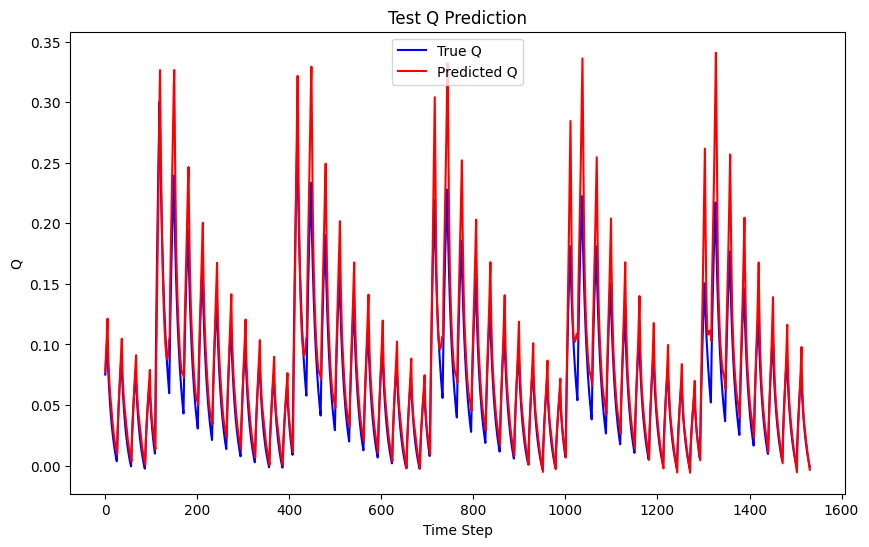

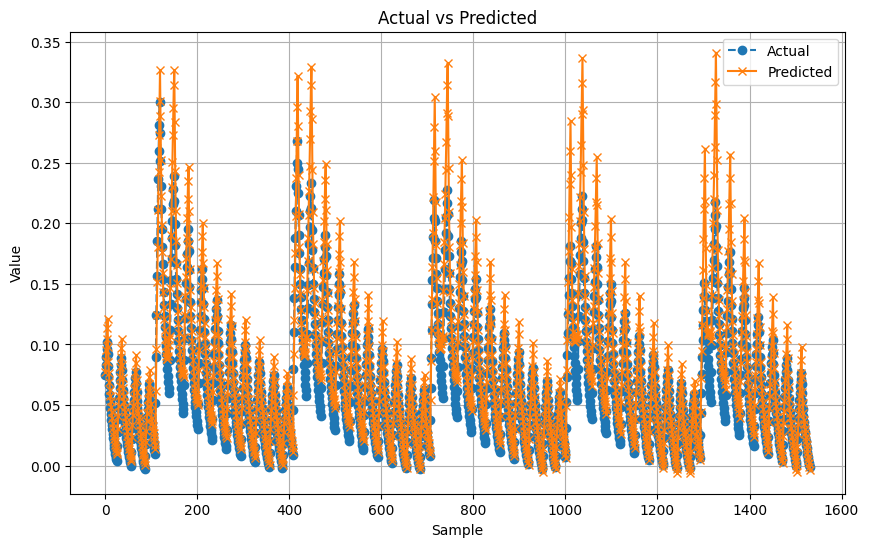

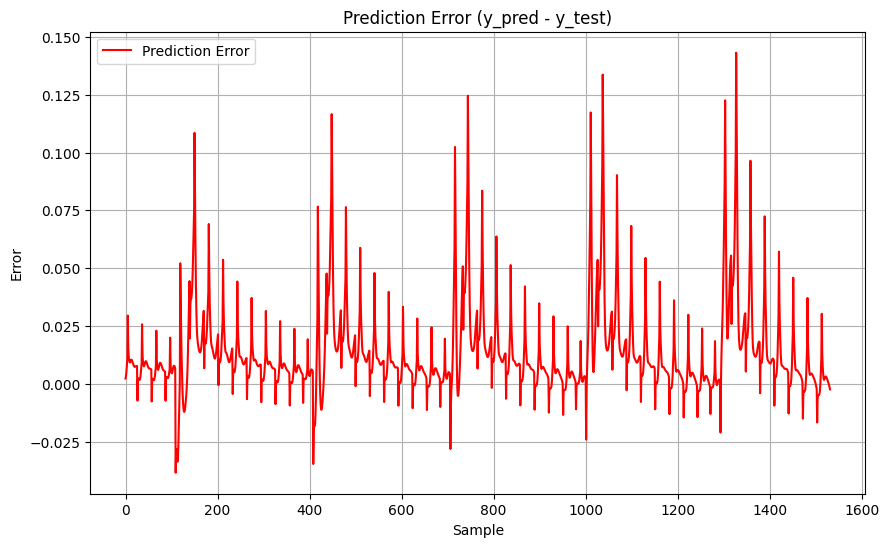

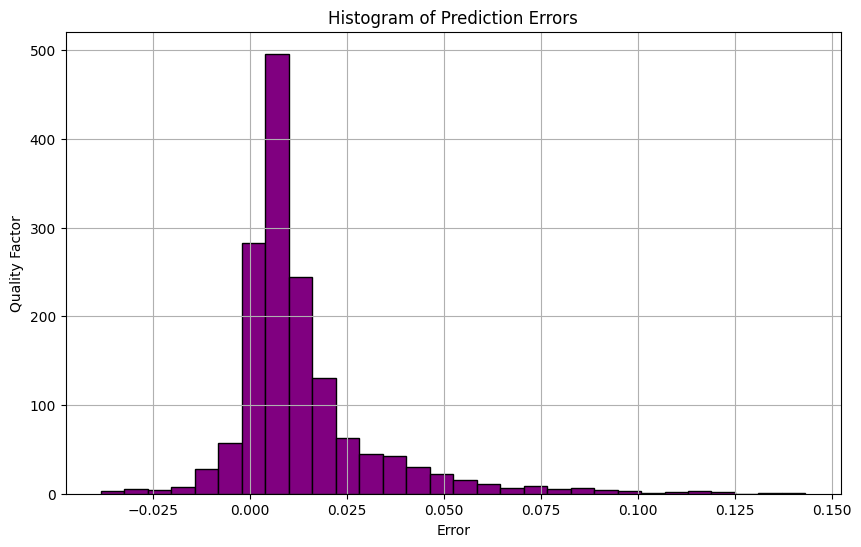

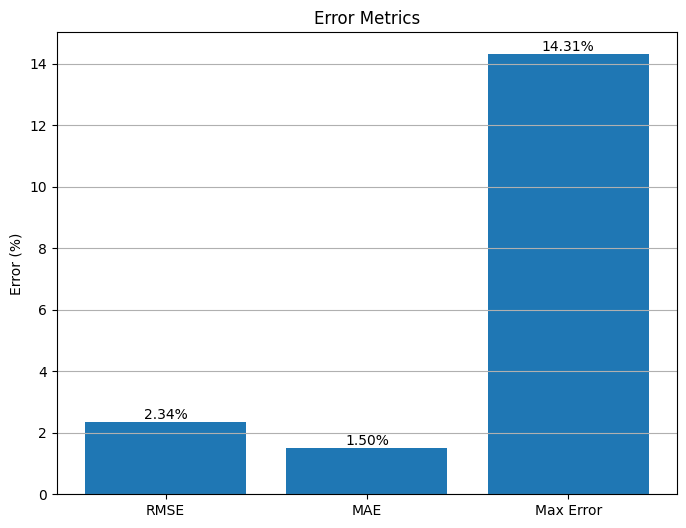

              Metric      Value
0               RMSE   0.023396
1                MAE   0.015022
2      Max Abs Error   0.143135
3  Mean Error (Bias)   0.013599
4  Std Dev of Errors   0.019038
5   Median Abs Error   0.009087
6          R-squared   0.794601
7               MAPE  39.308213


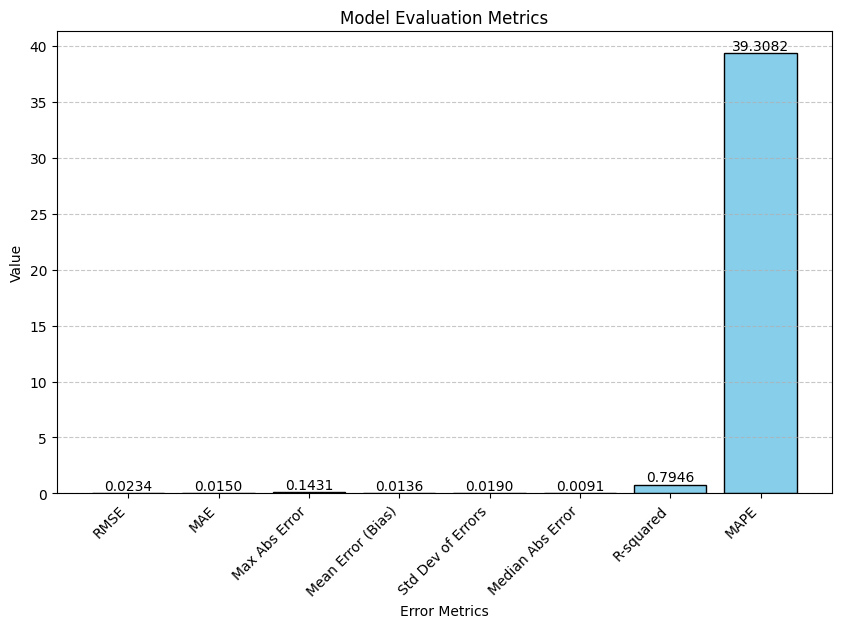

                               Metric     Value
       Root Mean Squared Error (RMSE)  0.023396
            Mean Absolute Error (MAE)  0.015022
                   Max Absolute Error  0.143135
                    Mean Error (Bias)  0.013599
         Standard Deviation of Errors  0.019038
                Median Absolute Error  0.009087
                      R-squared Score  0.794601
Mean Absolute Percentage Error (MAPE) 39.308213


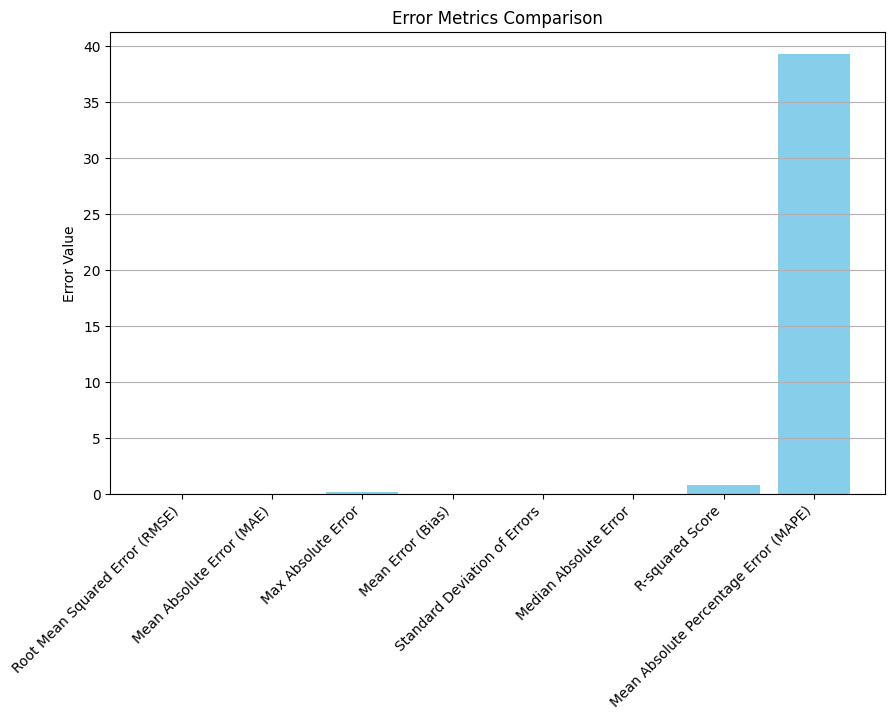

In [22]:
# 8. Evaluate the Model
N = 50
NN = 50

y_pred = final_model.predict(X_test, batch_size=32).flatten()

y_pred_trim = y_pred[N:len(y_pred)-NN]
y_test_trim = y_test[N:len(y_test)-NN]

error_test = y_pred_trim - y_test_trim
rmse = np.sqrt(np.mean(error_test ** 2)) * 100
mae = np.mean(np.abs(error_test)) * 100
max_error = np.max(np.abs(error_test)) * 100

print(f'Test RMSE: {rmse:.4f}%')
print(f'Test MAE: {mae:.4f}%')
print(f'Test MAX: {max_error:.4f}%')

# 9. Plot 1: Predictions in the Time Domain
plt.figure(figsize=(10, 6))
plt.plot(y_test_trim, 'b', linewidth=1.5, label='True Q')
plt.plot(y_pred_trim, 'r', linewidth=1.5, label='Predicted Q')
plt.xlabel('Time Step')
plt.ylabel('Q')
plt.title('Test Q Prediction')
plt.legend()
plt.show()

# Plot 2: Predicted vs Actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test_trim, label='Actual', marker='o', linestyle='--')
plt.plot(y_pred_trim, label='Predicted', marker='x', linestyle='-')
plt.title('Actual vs Predicted')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot 3: Error over samples
plt.figure(figsize=(10, 6))
plt.plot(error_test, label='Prediction Error', color='red')
plt.title('Prediction Error (y_pred - y_test)')
plt.xlabel('Sample')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

# Plot 4: Histogram of errors
plt.figure(figsize=(10, 6))
plt.hist(error_test, bins=30, color='purple', edgecolor='black')
plt.title('Histogram of Prediction Errors')
plt.xlabel('Error')
plt.ylabel('Quality Factor')
plt.grid(True)
plt.show()

# Plot 5: Bar Chart of Error Metrics
error_metrics = ['RMSE', 'MAE', 'Max Error']
values = [rmse, mae, max_error]

plt.figure(figsize=(8, 6))
bars = plt.bar(error_metrics, values)
plt.title('Error Metrics')
plt.ylabel('Error (%)')

# Annotate each bar with its value
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}%', ha='center', va='bottom')

plt.grid(axis='y')
plt.show()

from sklearn.metrics import mean_absolute_error, max_error, r2_score, median_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Compute additional error metrics
rmse = np.sqrt(mean_squared_error(y_test_trim, y_pred_trim))
mae = mean_absolute_error(y_test_trim, y_pred_trim)
max_abs_error = max_error(y_test_trim, y_pred_trim)
mean_error = np.mean(y_pred_trim - y_test_trim)
std_dev_error = np.std(y_pred_trim - y_test_trim)
median_abs_error = median_absolute_error(y_test_trim, y_pred_trim)
r2 = r2_score(y_test_trim, y_pred_trim)
mape = np.mean(np.abs((y_test_trim - y_pred_trim) / y_test_trim)) * 100

# Create a DataFrame for better visualization
error_df = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'Max Abs Error', 'Mean Error (Bias)', 'Std Dev of Errors', 'Median Abs Error', 'R-squared', 'MAPE'],
    'Value': [rmse, mae, max_abs_error, mean_error, std_dev_error, median_abs_error, r2, mape]
})

# Display the table
print(error_df)

# Plot error metrics in a bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(error_df['Metric'], error_df['Value'], color='skyblue', edgecolor='black')
plt.xlabel('Error Metrics')
plt.ylabel('Value')
plt.title('Model Evaluation Metrics')
plt.xticks(rotation=45, ha='right')

# Annotate each bar with its value
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.4f}', ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Compute error metrics
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

rmse = np.sqrt(mean_squared_error(y_test_trim, y_pred_trim))
mae = mean_absolute_error(y_test_trim, y_pred_trim)
max_error = np.max(np.abs(y_pred_trim - y_test_trim))
mean_error = np.mean(y_pred_trim - y_test_trim)
std_dev_error = np.std(y_pred_trim - y_test_trim)
median_error = median_absolute_error(y_test_trim, y_pred_trim)
r2 = r2_score(y_test_trim, y_pred_trim)
mape = mean_absolute_percentage_error(y_test_trim, y_pred_trim)

# Create DataFrame for error metrics
data = {
    "Metric": ["Root Mean Squared Error (RMSE)", "Mean Absolute Error (MAE)", "Max Absolute Error",
                "Mean Error (Bias)", "Standard Deviation of Errors", "Median Absolute Error",
                "R-squared Score", "Mean Absolute Percentage Error (MAPE)"],
    "Value": [rmse, mae, max_error, mean_error, std_dev_error, median_error, r2, mape]
}

results_df = pd.DataFrame(data)

# Display the table
print(results_df.to_string(index=False))

# Plot a bar chart of error metrics
plt.figure(figsize=(10, 6))
plt.bar(results_df["Metric"], results_df["Value"], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Error Value")
plt.title("Error Metrics Comparison")
plt.grid(axis='y')
plt.show()


